# Probablilistic Finite State Automata

In [1]:
%matplotlib inline
import logging
logging.basicConfig(level=logging.INFO)

from numpy import *
from myutil import HtmlPlugin
from wfsa import WFSA, PFSA, Sample, csra_matrix, FileBatch

from contextlib import contextmanager
from time import time
Tests = (
  ('avglen',dict(
    title='Expected length',
    empirical=lambda X,start,sample: sum([sum(batch!=X.stop) for batch,_ in sample.content])/sample.size,
    theoretical=lambda X,start: X.expected_length(start),
  )),
  ('entropy',dict(
    title='Entropy',
    empirical=lambda X,start,sample: -mean(X.logproba(sample,start)),
    theoretical=lambda X,start: X.entropy(start),
  )),
)
@contextmanager
def ptime():
  t = time()
  try:
    try: yield
    except: print('Error!',end=''); raise
  finally: print(' [{:.3g}s]'.format(time()-t))
def test(X,nsample,start=0,**alt):
  print(f'Deterministic: {X.deterministic}')
  print('Producing sample of size',nsample,end='',flush=True)
  with ptime():
    X.asample = sample = X.sample(nsample,start,store=FileBatch('samples',clear=True).store)
    print(' on {} batches'.format(len(sample.content)),end='')
  try:
    for key,D in Tests:
      print(D['title'])
      print('\tempirical  : ',end='',flush=True)
      with ptime(): v = D['empirical'](X,start,sample); print('{:.15g}'.format(v),end='')
      print('\ttheoretical: ',end='',flush=True)
      with ptime(): v = D['theoretical'](X,start); print('{:.15g}'.format(v),end='')
      v = alt.get(key)
      if v is not None: print('\talternative: {:.15g}'.format(v))
  finally:
    print('Sample ({}/{})'.format(10,nsample))
    sample.pprint(X.symb_names,10,translate={ord(X.symb_names[X.stop]):''})

## Basic example

INFO:wfsa.probabilistic:Inferred stop symbol and final state: . F


🛈,F,O,A,B
F,1.0,,,
O,0.2,,0.3,0.5
A,,0.2,0.8,
B,,0.4,,0.6


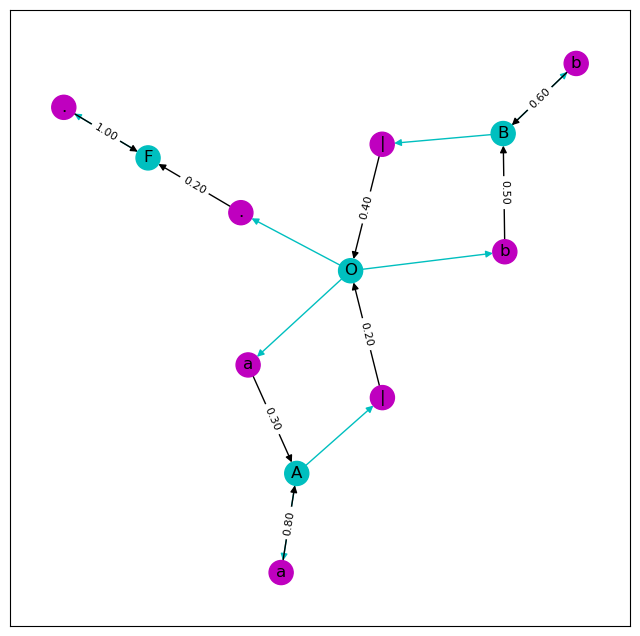

In [2]:
X = PFSA.from_str('''
F->F . 1.
O->A a .3
O->B b .5
O->F . .2
A->A a .8
A->O | .2
B->B b .6
B->O | .4
''')
X.draw(ax=dict(figsize=(8,8)))
X

Draw a large sample from state 'O'

In [3]:
sample = test(X,100000,start='O')

Deterministic: True
Producing sample of size 100000 on 15 batches [0.415s]
Expected length
	empirical  : 17.74401 [0.00547s]
	theoretical: 17.75 [4.08e-05s]
Entropy
	empirical  : 13.1019386538341 [0.641s]
	theoretical: 13.1076061656671 [0.000283s]
Sample (10/100000)
37120     6   aa|bb|
64919    14   aaaaa|bbb|b|b|
14608    26   aaaaaaaaaaaaa|bbbb|bb|b|b|
53283     2   b|
45123     5   bbbb|
87545     3   bb|
59455    14   b|a|bb|bbb|bb|
 9721    42   bbbbb|bbb|b|aa|aaaa|bbb|aa|bbbb|b|bbbbbbb|
53103    13   bbbbbbbb|b|b|
15588    24   bbbbb|aaaaaa|bb|bbbbbbb|


## Another example with super easy entropy

Closed form of entropy: $\frac{-p\log p-q\log q}{q}$

INFO:wfsa.probabilistic:Inferred stop symbol and final state: . F


🛈,F,O
F,1.0,
O,0.3,0.7


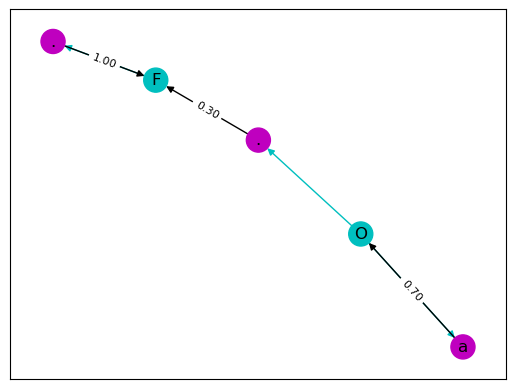

In [4]:
p = .7; q = 1.-p
X = PFSA.from_str(f'''
F->F . 1.
O->O a {p}
O->F . {q}
''')
X.draw(k=2,K=1)
X

In [5]:
sample = test(X,100000,start='O',avglen=p/q,entropy=-(p*log(p)+q*log(q))/q)

Deterministic: True
Producing sample of size 100000 on 12 batches [0.0524s]
Expected length
	empirical  : 2.32565 [0.00119s]
	theoretical: 2.33333333333333 [2.67e-05s]
	alternative: 2.33333333333333
Entropy
	empirical  : 2.03347388769705 [0.0938s]
	theoretical: 2.03621434018298 [0.000323s]
	alternative: 2.03621434018298
Sample (10/100000)
48336    2   aa
 7204    8   aaaaaaaa
38120    1   a
14572    4   aaaa
68734    2   aa
56945    2   aa
61874    1   a
37511    0   
30243    3   aaa
29676    3   aaa


## Other example with sparse matrices

Closed form of entropy: $L(-p\log p-q\log q)$

In [6]:
p =.7; L = 100; q = 1.-p
W = [*(z*eye(L+1,k=1) for z in (p,q)),zeros((L+1,L+1))]
W[-1][-1,-1] = 1
W = [csra_matrix.initial(w) for w in W]
X = PFSA(W,symb_names=('a','b','.'))
X

INFO:wfsa.probabilistic:Inferred stop symbol and final state: . 100


🛈


In [7]:
sample = test(X,10000,start=0,avglen=L,entropy=-L*(p*log(p)+q*log(q)))

Deterministic: True
Producing sample of size 10000 on 1 batches [0.0819s]
Expected length
	empirical  : 100 [0.00261s]
	theoretical: 100 [2.46e-05s]
	alternative: 100
Entropy
	empirical  : 61.1068500839247 [8.94s]
	theoretical: 61.0864302054893 [0.00151s]
	alternative: 61.0864302054893
Sample (10/10000)
 672   100   aaaabaaaabaaaaaaaabababbbaabaabaaaabaaaaaaaabbbbaaaabababbaaaaaababaaabaaaaaaaaaaababaaaaaaaabaabaaa
4718   100   abbbaabaaaababaaaaabbaaabbababbaaabaaaaaaaabaaaaaaaababbaaaaabaabbaaabbabaaaaaabaabbbaaaaaaaaabbbaaa
3847   100   aaaaabbaaaababaabaabbabababbabbababaabaaaaaaaaaababbaaaabaaabbbbbaabaaaabbaabaaabaaaaaaaaaabaaababaa
 197   100   abaaababaaaaababbbaaaaaabaaabaaaaabaababaaaababaaaaaaabaaabbbaabaabaaaaababaababaaaabaabaaaaabaaabaa
7698   100   bbaaaaaaababbbaabaaaabaaaaaabbaabababbbbbabaaaabbbbaaabaaaabaaaaabaaaabaaaaabbaaaaaababaaabababaaabb
5161   100   bbbabbbababbabbbbaaaaaaaaaaaabaaaaababaaaaaabaabbabaaabbaaaaababbaaaaabaaaaabbaaaaaabbabaabaaabbabaa
9521   100 

## Pruning

In [8]:
X = WFSA.from_str('''
F->F . 1.
O->A a .3
O->B b .5
O->F . .2
A->A a .8
A->O | .2
B->B b .6
B->O | .4
U->V | 1
U->V a 1
U->V b 1
V->U | 1
V->U a 1
V->U b 1
U->W | 1
U->W a 1
U->W b 1
V->W | 1
V->W a 1
V->W b 1
W->W | 0
''')
X

🛈,F,O,A,B,U,V,W
F,1.0,,,,,,
O,0.2,,0.3,0.5,,,
A,,0.2,0.8,,,,
B,,0.4,,0.6,,,
U,,,,,,3.0,3.0
V,,,,,3.0,,3.0
W,,,,,,,


INFO:wfsa.probabilistic:Inferred stop symbol and final state: . F
INFO:wfsa.probabilistic:Pruning unreachable states: 3/7


🛈,F,O,A,B
F,1.0,,,
O,0.2,,0.3,0.5
A,,0.2,0.8,
B,,0.4,,0.6


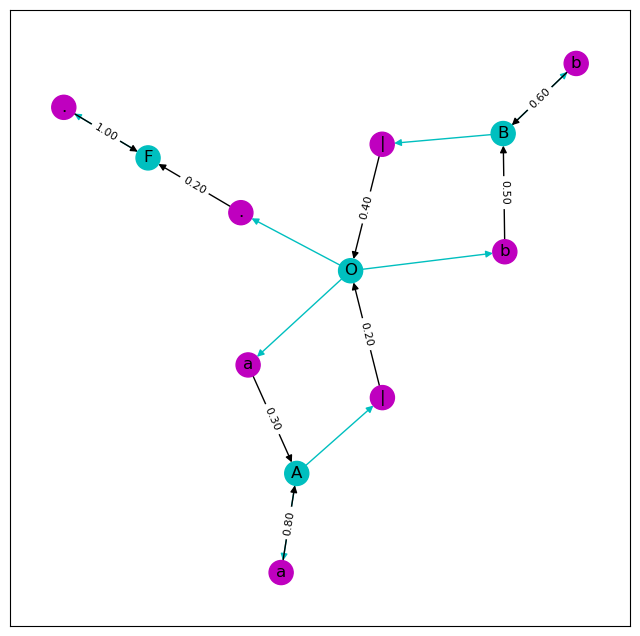

In [9]:
X = PFSA.fromWFSA(X)
X.draw(ax=dict(figsize=(8,8)))
X

## Intersection

In [43]:
L = 5
template,wstop = eye(L+1,k=1),zeros((L+1,L+1)); wstop[-1,-1] = 1.
template,wstop = map(csra_matrix.initial,(template,wstop))
X_len = WFSA([wstop],template=template,symb_names=('.',),state_names=[f'L{k}' for k in range(L,-1,-1)])

X_cnt = WFSA.from_str('''
O->O a 1.5
O->O b .5
O->O . 1
''',sparse=True)

X_mot = WFSA.from_str('''
O->A a 1
O->O b 1
A->F b 1
A->A a 1
F->F a 1
F->F b 1
F->F . 1
''',sparse=True)

X = X_cnt@X_mot@X_len
X

🛈,O.O.L5,O.O.L4,O.O.L3,O.O.L2,O.O.L1,O.O.L0,O.A.L5,O.A.L4,O.A.L3,O.A.L2,O.A.L1,O.A.L0,O.F.L5,O.F.L4,O.F.L3,O.F.L2,O.F.L1,O.F.L0
O.O.L5,,0.5,,,,,,1.5,,,,,,,,,,
O.O.L4,,,0.5,,,,,,1.5,,,,,,,,,
O.O.L3,,,,0.5,,,,,,1.5,,,,,,,,
O.O.L2,,,,,0.5,,,,,,1.5,,,,,,,
O.O.L1,,,,,,0.5,,,,,,1.5,,,,,,
O.O.L0,,,,,,,,,,,,,,,,,,
O.A.L5,,,,,,,,1.5,,,,,,0.5,,,,
O.A.L4,,,,,,,,,1.5,,,,,,0.5,,,
O.A.L3,,,,,,,,,,1.5,,,,,,0.5,,
O.A.L2,,,,,,,,,,,1.5,,,,,,0.5,


INFO:wfsa.probabilistic:Inferred stop symbol and final state: . O.F.L0
INFO:wfsa.probabilistic:Pruning unreachable states: 3/18
INFO:wfsa.probabilistic:Normaliser min: 0.5 max: 32.0


🛈,O.O.L5,O.O.L4,O.O.L3,O.O.L2,O.A.L5,O.A.L4,O.A.L3,O.A.L2,O.A.L1,O.F.L5,O.F.L4,O.F.L3,O.F.L2,O.F.L1,O.F.L0
O.O.L5,,0.2,,,,0.8,,,,,,,,,
O.O.L4,,,0.18,,,,0.82,,,,,,,,
O.O.L3,,,,0.12,,,,0.88,,,,,,,
O.O.L2,,,,,,,,,1.0,,,,,,
O.A.L5,,,,,,0.67,,,,,0.33,,,,
O.A.L4,,,,,,,0.63,,,,,0.37,,,
O.A.L3,,,,,,,,0.57,,,,,0.43,,
O.A.L2,,,,,,,,,0.43,,,,,0.57,
O.A.L1,,,,,,,,,,,,,,,1.0
O.F.L5,,,,,,,,,,,1.0,,,,


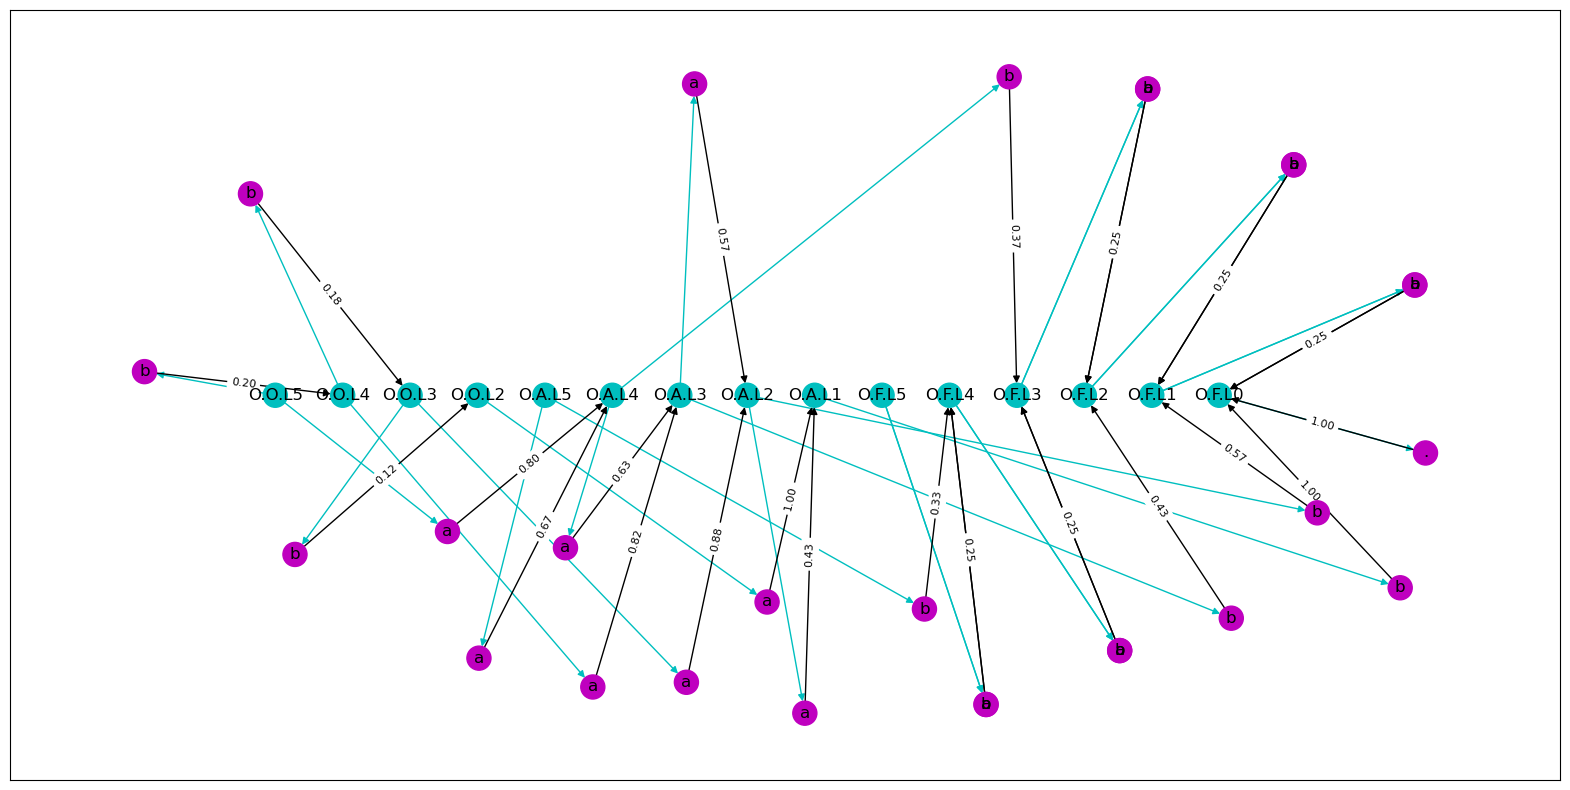

In [44]:
X = PFSA.fromWFSA(X)
X.draw(ax=dict(figsize=(20,10)),k=6.,weight=None) # some edges (pink nodes) overlap
X

In [45]:
def allstr(X,L):
  R = [c for c in range(X.n) if c!=X.stop]
  m = X.n-1
  sample = empty((L+1,Q),dtype=int)
  sample[L] = X.stop
  for k in range(L): sample[k] = tile(repeat(R,m**(L-1-k)),m**k)
  return sample
Q = (X.n-1)**L
sample = Sample(Q)
sample.append(allstr(X,L))
X.asample = sample.close()

P = exp(X.logproba(sample,start=0))
for x,p in zip(sample.values(),P): print(''.join(X.symb_names[c] for c in x),p)
print('Total probability:',sum(P))
print('Entropy:',X.entropy(start=0))

aaaaa. 0.0
aaaab. 0.12272727272727268
aaaba. 0.12272727272727274
aaabb. 0.040909090909090916
aabaa. 0.12272727272727274
aabab. 0.040909090909090916
aabba. 0.040909090909090916
aabbb. 0.013636363636363634
abaaa. 0.12272727272727274
abaab. 0.040909090909090916
ababa. 0.040909090909090916
ababb. 0.013636363636363634
abbaa. 0.040909090909090916
abbab. 0.013636363636363634
abbba. 0.013636363636363634
abbbb. 0.0045454545454545435
baaaa. 0.0
baaab. 0.040909090909090916
baaba. 0.040909090909090916
baabb. 0.013636363636363634
babaa. 0.040909090909090916
babab. 0.013636363636363634
babba. 0.013636363636363634
babbb. 0.0045454545454545435
bbaaa. 0.0
bbaab. 0.013636363636363634
bbaba. 0.013636363636363634
bbabb. 0.0045454545454545435
bbbaa. 0.0
bbbab. 0.004545454545454548
bbbba. 0.0
bbbbb. 0.0
Total probability: 1.0
Entropy: 2.8318634368671782


## Entropy not computable

INFO:wfsa.probabilistic:Inferred stop symbol and final state: . F


🛈,F,O,B,A3,A2,A1,A0
F,1.0,,,,,,
O,0.15,,0.25,0.3,0.2,0.1,
B,,0.2,0.8,,,,
A3,,,,,1.0,,
A2,,,,,,1.0,
A1,,,,,,,1.0
A0,,1.0,,,,,


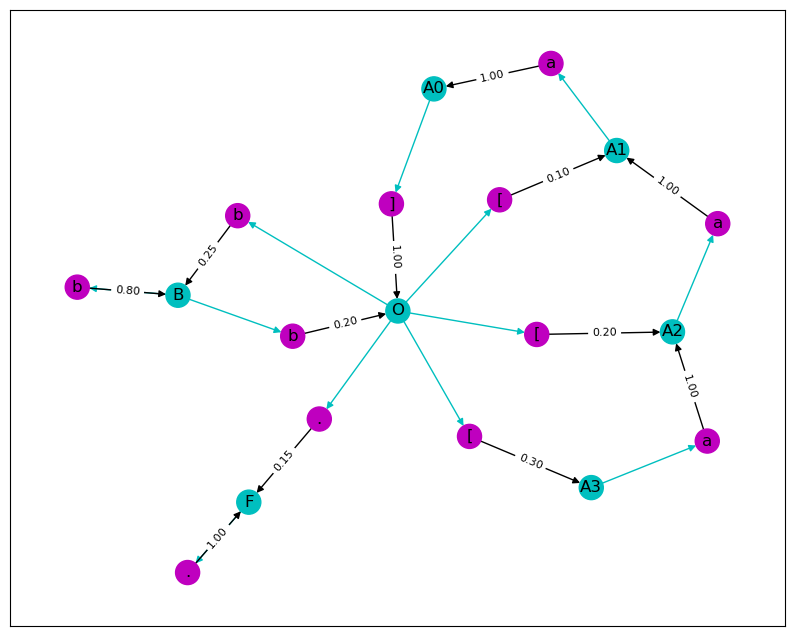

In [17]:
X = PFSA.from_str('''
F->F . 1.
O->A3 [ .3
O->A2 [ .2
O->A1 [ .1
O->B b .25
O->F . .15
B->B b .8
B->O b .2
A3->A2 a 1.
A2->A1 a 1.
A1->A0 a 1.
A0->O ] 1.
''')
X.draw(ax=dict(figsize=(10,8)),layout='kamada_kawai')
X

In [18]:
sample = test(X,10000,start='O')

Deterministic: False
Producing sample of size 10000 on 9 batches [0.237s]
Expected length
	empirical  : 27.3914 [0.00109s]
	theoretical: 27.3333333333333 [4.17e-05s]
Entropy
	empirical  : 12.9564454127415 [0.17s]
	theoretical: Error! [3.91e-05s]
Sample (10/10000)
4202    16   [a][aa][aa]bbbbb
7120     0   
9932     5   [aaa]
5500    27   bbbbbbbb[aa][aa][aaa]bbbbbb
1003    81   [aa]bbbbbbbbb[aaa][aa][aa]bbbbbbbbbbbbbb[aaa][aa]bbbbbbbbbbbbbbbbbb[aa][aaa][aaa]
1591    42   [aaa][aa][aaa][a][aaa][aa][aa]bbbb[a][aaa]
1322    62   [aaa][aa]bb[aa][aaa][aa][aa]bb[aaa]bbbbbb[a]bbbbbbb[a][aa]bbbb
3728     0   
4900     0   
 279   117   [aa][aaa][a][aa][aaa][aaa]bbb[aaa][aaa][aaa]bbbbbbbbbb[aa]bbbbbbbbbbbbbbbbbbbbbbb[aa][aa][aa][aa][aaa][aa][aa][aa]bbb


NotImplementedError: Entropy available only for deterministic automata

# Sample management

In [15]:
R = FileBatch('samples')
sample = R.toSample()
sample

In [16]:
sample.pprint('[b.a]',pick=10,translate={ord('.'):''})

9254    19   [aaa][aaa][aaa][aa]
 947    85   [aa][aa]bbbbbbbbbbbbbb[aa][aa][aaa][a][aa]bbbbbbbb[aaa]bb[aa][aaa][aaa][a][a][aaa]bbb
2452    32   [aa][aaa]bbbbbbbbb[aaa][aaa][aa]
4872     5   [aaa]
8900    27   [a][a]bbbbbb[aaa][aaa][aaa]
5941     0   
4528    10   [a][aa][a]
8909     7   [aaa]bb
6740     0   
8842    13   [aa][aa][aaa]
